# CSCIE63 - Linear Regression Example

### Our Task - Build a Linear Regression Model to Predict HorsePower given Displacement

In [29]:
import os
import pyspark.mllib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark

from pyspark import SparkContext, SparkConf
from pyspark.sql import Row
from IPython.display import display, HTML
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.regression import LinearRegressionWithSGD 
from pyspark.sql.functions import *
from pyspark.sql import SQLContext

In [30]:
# Setup your Spark context 
conf = (SparkConf()
         .setMaster("local[*]")
         .setAppName("e63CarsLinear")
         .set("spark.executor.memory", "2g"))

# Use get or create here so that if the cell is evaluated multiple times we don't get multiple SparkContexts.
sc = SparkContext.getOrCreate(conf)
sqlContext = SQLContext(sc)

In [31]:
# Load all your Data 

auto = sc.textFile("auto_mpg_original.csv", use_unicode=False)
autordd = auto.map(lambda line: line.split(","))
num_data = autordd.count()
print ('Total Count:' + str(num_data))

Total Count:406


In [32]:
# Map the RDD Colums in prep to clean up as well as do preliminary Data Analysis 

mappedautordd = autordd.map(lambda line: Row(mpg=line[0],cylinders=line[1], displacement=line[2], horsepower=line[3], weight=line[4], acceleration=line[5], my=line[6],origin=line[7],name=line[8]))

In [38]:
mappedautordd.take(5)
mappedautordd

PythonRDD[216] at RDD at PythonRDD.scala:48

In [34]:
# Clean up our Data remove the N/A

df = mappedautordd.toDF()
df = df.filter(df['mpg'] > 0)
df = df.filter(df['horsepower'] > 0)
num_data = df.count()
print ('Total Count:' + str(num_data))
df.take(5)

Total Count:404


[Row(acceleration=u'12', cylinders=u'8', displacement=u'307', horsepower=u'130', mpg=u'18', my=u'70', name=u'chevrolet', origin=u'1', weight=u'3504'),
 Row(acceleration=u'11.5', cylinders=u'8', displacement=u'350', horsepower=u'165', mpg=u'15', my=u'70', name=u'buick', origin=u'1', weight=u'3693'),
 Row(acceleration=u'11', cylinders=u'8', displacement=u'318', horsepower=u'150', mpg=u'18', my=u'70', name=u'plymouth', origin=u'1', weight=u'3436'),
 Row(acceleration=u'12', cylinders=u'8', displacement=u'304', horsepower=u'150', mpg=u'16', my=u'70', name=u'amc', origin=u'1', weight=u'3433'),
 Row(acceleration=u'10.5', cylinders=u'8', displacement=u'302', horsepower=u'140', mpg=u'17', my=u'70', name=u'ford', origin=u'1', weight=u'3449')]

In [37]:
#Summary of our Input Data

df2 = df.select(df.displacement.cast('float'),df.horsepower.cast('float')) 
df2.take(2)
df2.describe('displacement', 'horsepower').show()
df2

+-------+------------------+------------------+
|summary|      displacement|        horsepower|
+-------+------------------+------------------+
|  count|               404|               404|
|   mean|195.19678217821783|104.82425742574257|
| stddev|105.01135004018664| 38.70267532885791|
|    min|              68.0|              46.0|
|    max|             455.0|             230.0|
+-------+------------------+------------------+



DataFrame[displacement: float, horsepower: float]

Populating the interactive namespace from numpy and matplotlib


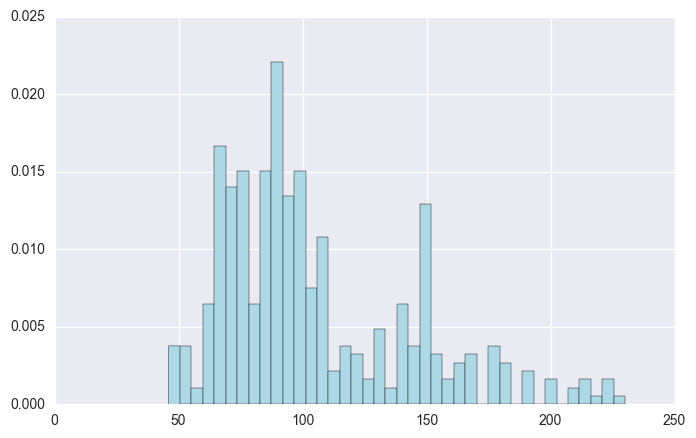

In [39]:
# Look at the distribution of our Data 

%pylab inline
targets = df.select(df.horsepower.cast('float')).rdd.flatMap(lambda x: x).collect()
hist(targets, bins=40, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 5)

In [40]:
# Setup some functions we could use later . 
# Alternative is to use Spark builtin RegressionMetrics

def squared_error(actual, pred): 
    return (pred - actual)**2
def abs_error(actual, pred): 
    return np.abs(pred - actual)
def squared_log_error(pred, actual):
    return (np.log(pred + 1) - np.log(actual + 1))**2

In [41]:
# Create our Training and Test Data 

# LabeledPoint
transformed = df2.rdd.map(lambda r : LabeledPoint(r[0],r[1:])) 

print "---------------------------------"
print "How does Labeled Point Look like "
print "---------------------------------"
print " "
print transformed.take(5)
print " "
# Split our Data 

print "---------------------------------"
print "Splitting our Data"
print "---------------------------------"


trainingData, testingData = transformed.randomSplit([.8,.2],seed=1234)
train_size = trainingData.count()
test_size = testingData.count()
print "Training data size: %d" % train_size
print "Test data size: %d" % test_size
print "Total data size: %d " % num_data
print "Train + Test size : %d" % (train_size + test_size)
trainingData = trainingData.cache()
testingData = testingData.cache()

print""
print"---------------------"
print" VIEW OUR TESTDATA "
print"---------------------"


print testingData.take(5)

---------------------------------
How does Labeled Point Look like 
---------------------------------
 
[LabeledPoint(307.0, [130.0]), LabeledPoint(350.0, [165.0]), LabeledPoint(318.0, [150.0]), LabeledPoint(304.0, [150.0]), LabeledPoint(302.0, [140.0])]
 
---------------------------------
Splitting our Data
---------------------------------
Training data size: 328
Test data size: 76
Total data size: 404 
Train + Test size : 404

---------------------
 VIEW OUR TESTDATA 
---------------------
[LabeledPoint(133.0, [115.0]), LabeledPoint(200.0, [85.0]), LabeledPoint(113.0, [95.0]), LabeledPoint(97.0, [48.0]), LabeledPoint(232.0, [100.0])]


In [43]:
# We train our Model now 
# Please note use LinearRegressionWithSGD ONLY 

linearModel = LinearRegressionWithSGD.train(trainingData,iterations=10000,step=.001)

print("Linear Model Info:" + str (linearModel))

# We validate our Model against training Data
print "---------------------------------"
print "Predictions"
print "---------------------------------"
print ""

true_vs_predicted = testingData.map(lambda p: (p.label, linearModel.predict(p.features)))
print ("Linear Model predictions: " + str(true_vs_predicted.take(10))) 
print ""
# Gather Metrics 
mse = true_vs_predicted.map(lambda (t, p): squared_error(t, p)).mean() 
mae = true_vs_predicted.map(lambda (t, p): abs_error(t, p)).mean() 
rmsle=np.sqrt(true_vs_predicted.map(lambda(t,p):squared_log_error(t,p)).mean())


print "---------------------------------"
print "Model Metrics"
print "---------------------------------"
print ""

print ("Linear Model - Mean Squared Error: %2.4f" % mse)
print ("Linear Model - Mean Absolute Error: %2.4f" % mae)
print ("Linear Model - Root Mean Squared Log Error: %2.4f" % rmsle)



Linear Model Info:(weights=[1.92789641833], intercept=0.0)
---------------------------------
Predictions
---------------------------------

Linear Model predictions: [(133.0, 221.70808810753812), (200.0, 163.87119555774558), (113.0, 183.15015974100976), (97.0, 92.539028079668086), (232.0, 192.78964183264185), (351.0, 294.96815200394201), (383.0, 347.02135529875534), (250.0, 192.78964183264185), (79.0, 134.95274928284928), (88.0, 146.52012779280781)]

---------------------------------
Model Metrics
---------------------------------

Linear Model - Mean Squared Error: 2113.1806
Linear Model - Mean Absolute Error: 39.7686
Linear Model - Root Mean Squared Log Error: 0.2958


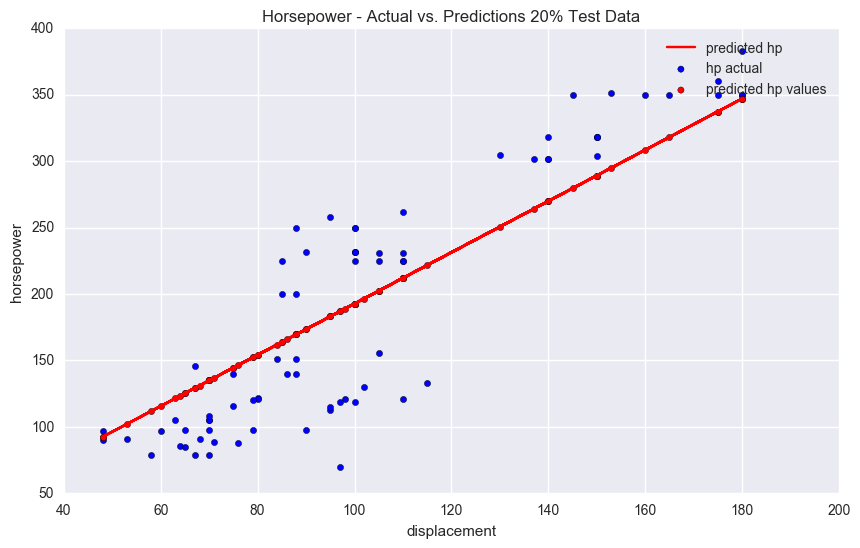

In [44]:
tvp = testingData.map(lambda p: (float(p.label), float(linearModel.predict(p.features)), float(p.features[0]))).toDF().toPandas()
tvp.columns = ['horsepower', 'predicted horsepower', 'displacement']

# Plot for 20% of Train Data

plt.figure(1, figsize=(10,6))
plt.scatter(tvp['displacement'], tvp['horsepower'], c='b', label='hp actual')
plt.plot(tvp['displacement'], tvp['predicted horsepower'], c='r',label='predicted hp')
plt.scatter(tvp['displacement'], tvp['predicted horsepower'], c='r', label='predicted hp values')
plt.xlabel('displacement')
plt.ylabel('horsepower')
plt.title('Horsepower - Actual vs. Predictions 20% Test Data')
plt.legend()
plt.show()

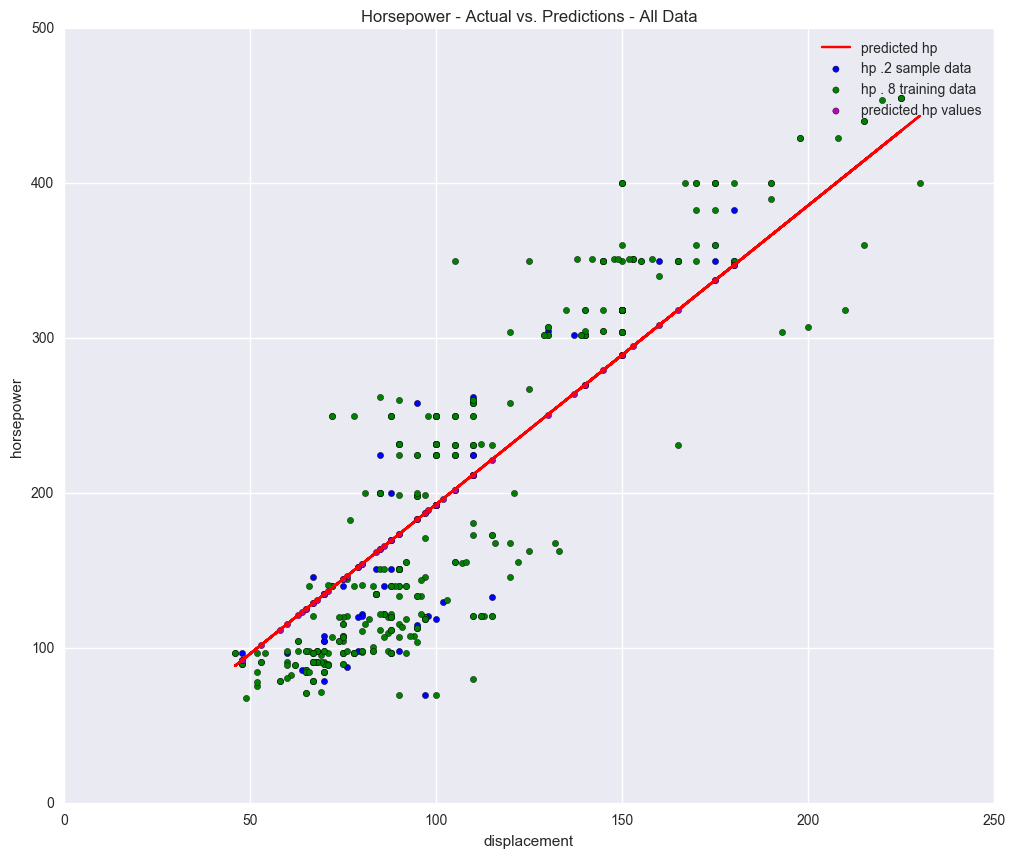

In [46]:
# Plot for 20% of All Data

plt.figure(2, figsize=(12,10))
tvp2 = trainingData.map(lambda p: (float(p.label), float(linearModel.predict(p.features)), float(p.features[0]))).toDF().toPandas() 
tvp2.columns = ['horsepower', 'predicted horsepower', 'displacement'] 
plt.scatter(tvp['displacement'], tvp['horsepower'], c='b', label='hp .2 sample data')
plt.scatter(tvp2['displacement'], tvp2['horsepower'], c='g', label='hp . 8 training data')
plt.plot(tvp2['displacement'], tvp2['predicted horsepower'], c='r', label='predicted hp')
plt.scatter(tvp['displacement'], tvp['predicted horsepower'], c='m', label='predicted hp values')
plt.xlabel('displacement')
plt.ylabel('horsepower')
plt.legend()
plt.title('Horsepower - Actual vs. Predictions - All Data')
plt.show()